c:\users\takumi\onedrive\ドキュメント\github\chemistry\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.871e-04, tolerance: 2.808e-04
  model = cd_fast.enet_coordinate_descent(
c:\users\takumi\onedrive\ドキュメント\github\chemistry\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.141e-04, tolerance: 2.042e-04
  model = cd_fast.enet_coordinate_descent(


best value of parameters : {'alpha': 0.46069672044533166, 'rho': 0.026871819947089582}
Test Score via Optimized Parameters : -0.1954007019210393


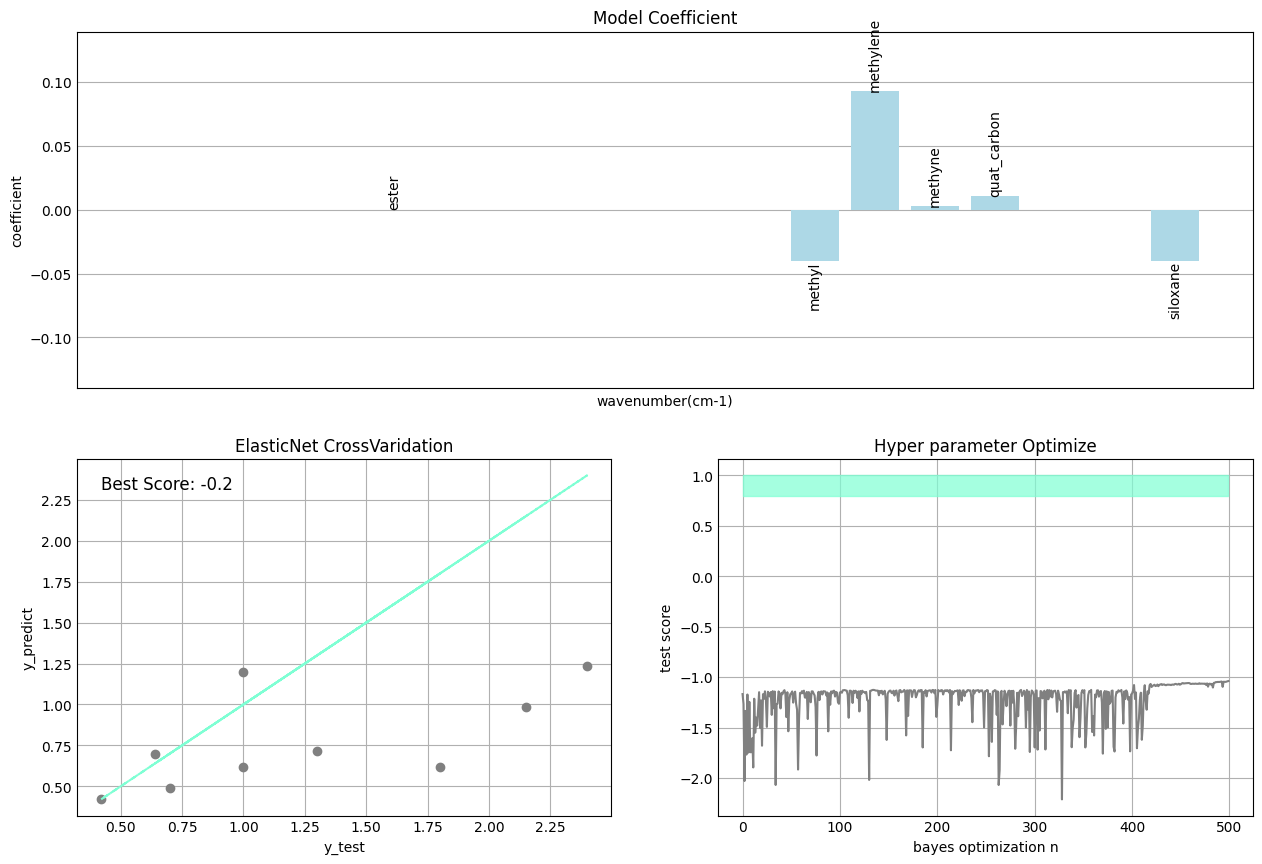

In [3]:
import pandas as pd 
from rdkit import Chem
from rdkit.Chem import rdChemReactions
from rdkit.Chem import AllChem
import os
import PySimpleGUI as sg


df = pd.read_csv("CSV/output.csv",index_col = "Tag")
materials = df.index.tolist()
properties = df.columns.tolist()[3:] #官能基の情報のみ


#機械学習用データフレーム 
try:
    products_df = pd.read_csv("CSV/products.csv")
except:
    products_df = pd.DataFrame(columns=["Name","Object Val"]+properties)

# GUIのレイアウト
sg.theme("DarkBrown")

layout = [[sg.Text('ChemReacter', font=('Constantia',20))],
          [sg.Text("")],
          [sg.Button("Calculate"),sg.Button("Delete")],
          [sg.Text("Sample Name",size=(20, 1)), sg.Input(size=(20, 1),key = "sample_name" )],
          [sg.Text("Value",size=(20, 1)), sg.Input(size=(20, 1),key = "val" )],
          [sg.Text('_'  * 100)], #横線区切り
          [sg.Column(layout=[
                  [sg.Combo(materials, size=(20, 1), key=f'material_{n}'),
                   sg.Input("0", size=(20, 1), key=f"feed_{n}")] for n in range(10)],
              scrollable=True,  # スクロール可能に設定
              vertical_scroll_only=True,  # 垂直方向のスクロールのみ
              size=(400, 500)  # 列全体のサイズ
              ),
           sg.Column(layout=[
              [sg.Text(property, size=(20, 1), key=f'{property}'),
               sg.Text("-", size=(20, 1), key=f"{property}_val")] for property in properties],
              size=(350, 500)),
           sg.Table(headings =["Name"],values = [[elem] for elem in products_df["Name"].tolist()],
                    key ="output_table",
                    size=(10,30))
          ]]
# ウインドウの出現位置を指定
win_location = (0, 0)
window = sg.Window("ChemFind", layout,resizable=True,location=win_location)


while True:
    
    event, values = window.read()

    if event == sg.WINDOW_CLOSED:
        break
        
    if event == "Calculate":

        #出力用dict
        output={} 
        for property in properties:
            calc_val = []
            feed_sum = []
            
            for i in range(10):
                material_name = values[f"material_{i}"]
                if material_name != "":  #materialnameに入力されている場合のみデータ参照可能
                    feed = float(values[f"feed_{i}"])
                    calc_val.append(df.loc[material_name,property]*feed)
                    feed_sum.append(feed)

            #目的変数値の記録
            output["Name"] = [values["sample_name"]]
            #目的変数値の記録
            output["Object Val"] = [values["val"]]
            #官能基情報の記録
            output[property] = [sum(calc_val)/sum(feed_sum)]
            window[f"{property}_val"].update(output[property]) 
        #データフレームに新しいデータ行を追加
        new_row = pd.DataFrame(output)
        products_df = pd.concat([products_df,new_row])
        window["output_table"].update([[elem] for elem in products_df["Name"].tolist()])



    if event == "Delete":
        try:
                
            products_df = products_df.drop(products_df.index[-1])
            window["output_table"].update([[elem] for elem in products_df["Name"].tolist()])
        except:
            pass

products_df.to_csv("CSV/products.csv",index=False)
window.close()

products_df = products_df.drop(columns=["Name","logP"])

y = products_df["Object Val"]
X = products_df.drop(columns=["Object Val"])
properties = [word.replace(" (mmol/g)","") for word in X.columns.to_list()]

y_ = y.to_numpy().astype(float)
X_ = X.to_numpy().astype(float)

from modules import bayes_EN as ben
ben.Elastic_Net(properties,X_,y_,0.8,500)

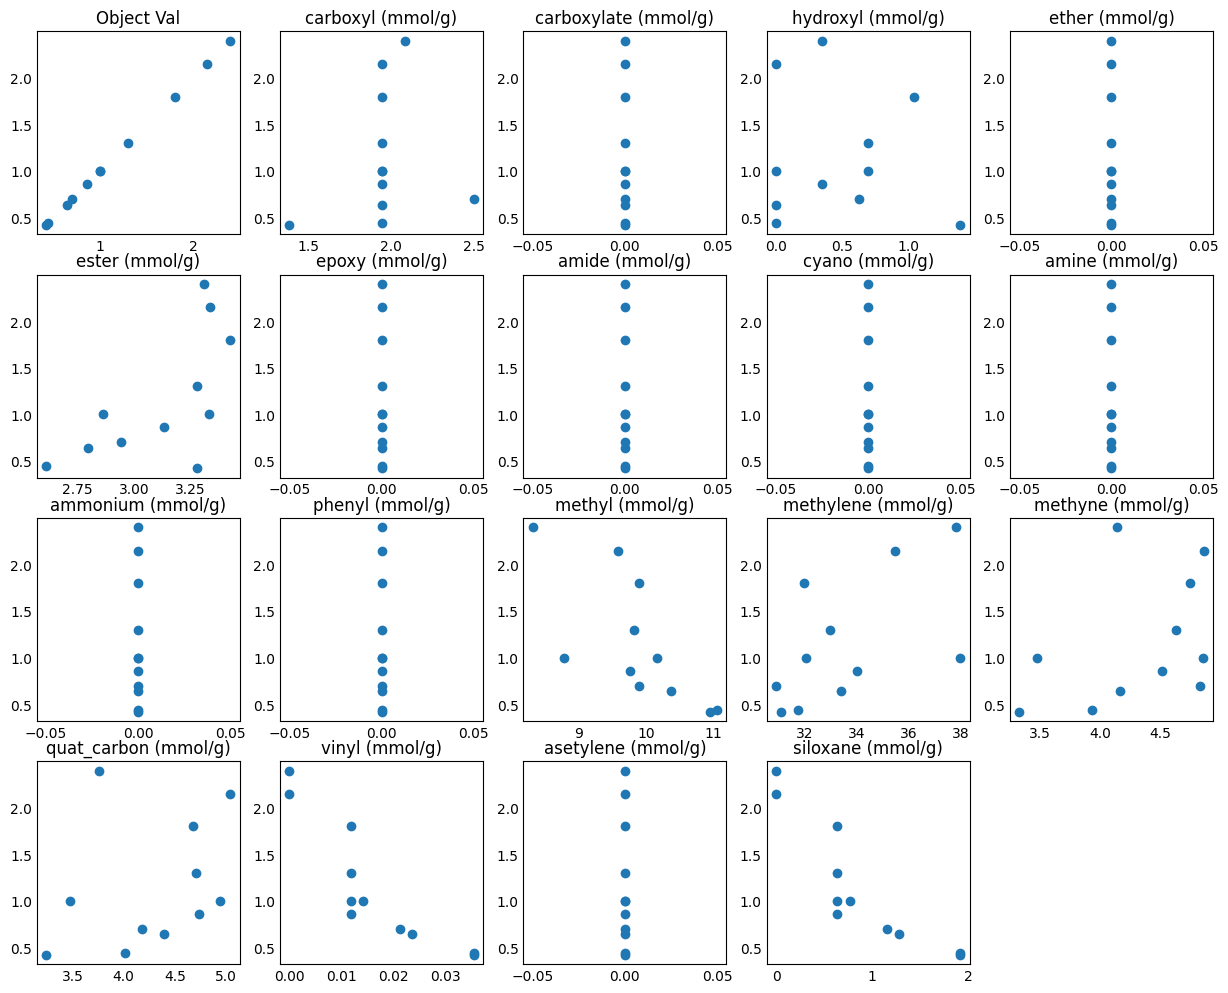

In [27]:
import matplotlib.pyplot as plt 
ls = products_df.columns.to_list()

#結果の可視化
plt.figure(figsize=(12,12))
plt.style.use("_mpl-gallery-nogrid")

for n,elem in enumerate(ls):
    x = products_df[elem]
    y = products_df["Object Val"]
    plt.subplot(5,5,n+1)
    plt.scatter(x,y)
    plt.title(elem)